##### source: https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix

In [1]:
import findspark
findspark.init()

import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

spark_session = SparkSession.Builder().appName('Movie_Recommender') \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]").getOrCreate()
spark_context = spark_session.sparkContext

In [2]:
movies = spark_session.read.load("data/spark-movie-movies.dat", format='csv', header=True, inferSchema=True)
movies.show(5, truncate=True)

+--------+--------------------+--------------------+
|movie_id|               title|              genres|
+--------+--------------------+--------------------+
|       1|    Toy Story (1995)|Animation|Childre...|
|       2|      Jumanji (1995)|Adventure|Childre...|
|       3|Grumpier Old Men ...|      Comedy|Romance|
|       4|Waiting to Exhale...|        Comedy|Drama|
|       5|Father of the Bri...|              Comedy|
+--------+--------------------+--------------------+
only showing top 5 rows



In [3]:
ratings = spark_session.read.load("data/spark-movie-ratings.dat", format='csv', header=True, inferSchema=True)
ratings.show(5,truncate=True)

+-------+--------+------+---------+
|user_id|movie_id|rating|timestamp|
+-------+--------+------+---------+
|      1|    1193|     5|978300760|
|      1|     661|     3|978302109|
|      1|     914|     3|978301968|
|      1|    3408|     4|978300275|
|      1|    2355|     5|978824291|
+-------+--------+------+---------+
only showing top 5 rows



#### Spark SQL and OLAP

##### What are the ratings?

In [ ]:
print('Distinct values of ratings:')
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

##### What is minimum number of ratings per user and minimum number of ratings per movie?

In [ ]:
tmp1 = ratings.groupBy("user_id").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movie_id").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

##### How many movies are rated by only one user?

In [ ]:
tmp1 = sum(ratings.groupBy("movie_id").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movie_id').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

##### What is the total number of users in the data sets?

In [ ]:
tmp = ratings.select('user_id').distinct().count()
print('We have a total of {} distinct users in the data sets'.format(tmp))

##### What is the total number of movies in the data sets?

In [ ]:
tmp = movies.select('movie_id').distinct().count()
print('We have a total of {} distinct movies in the data sets'.format(tmp))

##### How many movies are rated by users? List movies not rated yet?

In [ ]:
tmp1 = movies.select('movie_id').distinct().count()
tmp2 = ratings.select('movie_id').distinct().count()
print('We have a total of {} distinct movies that are rated by users in ratings table'.format(tmp2))
print('We have {} movies that are not rated yet'.format(tmp1-tmp2))

In [ ]:
# create a temp SQL table view for easier query
movies.createOrReplaceTempView("movies")
ratings.createOrReplaceTempView("ratings")
print('List movies that are not rated yet: ')
# SQL query (NOTE: WHERE ... NOT IN ... == ... LEFT JOIN ... WHERE ... IS NULL)
# Approach 1
spark_session.sql(
    "SELECT movie_id, title "
    "FROM movies "
    "WHERE movie_id NOT IN (SELECT distinct(movie_id) FROM ratings)"
).show(10)
# Approach 2
# spark.sql(
#     "SELECT m.movieId, m.title "
#     "FROM movies m LEFT JOIN ratings r ON m.movieId=r.movieId "
#     "WHERE r.movieId IS NULL"
# ).show(10)

##### List all movie genres

In [ ]:
splitter = UserDefinedFunction(lambda x: x.split('|'), ArrayType(StringType()))
# query
print('All distinct genres: ')
movies.select(explode(splitter("genres")).alias("genres")).distinct().show()

##### Find out the number of movies for each category

In [ ]:
print('Counts of movies per genre')
movies.select('movie_id', explode(splitter("genres")).alias("genres")) \
    .groupby('genres') \
    .count() \
    .sort(desc('count')) \
    .show()

#### Spark ALS based approach for training model

##### Reload data
##### We will use an RDD-based API from pyspark.mllib to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.

In [5]:
movie_rating = spark_context.textFile('data/spark-movie-ratings.dat')
# preprocess data -- only need ["user_id", "movie_id", "rating"]
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()
# check three rows
rating_data.take(3)

[(1, 1193, 5.0), (1, 661, 3.0), (1, 914, 3.0)]

##### Split data
##### Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [9]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[43] at RDD at PythonRDD.scala:53

#### ALS model selection and evaluation
##### With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [12]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
        
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [14]:
training = True
if training == True:
    # hyper-param config
    num_iterations = 10
    ranks = [8, 10, 12, 14, 16, 18, 20]
    reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

    # grid search and select best model
    start_time = time.time()
    model = train_ALS(train, validation, num_iterations, reg_params, ranks)
    
    # Save model
    model.save(spark_context, "model/spark-collaborative-filter")
    print('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))
else:
    # load model
    model = MatrixFactorizationModel.load(spark_context, "model/spark-collaborative-filter")

#### ALS model learning curve
##### as we increase number of iterations in training ALS, we can see how RMSE changes and whether or not model is overfitted.

In [21]:
training = True
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    if training == True:
        errors = []
        for num_iters in arr_iters:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (user_id, movie_id, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)

            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))

            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)

            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)

            # add to errors
            errors.append(error)

        # save model
        model.save(spark_context, "model/spark-collaborative-filter")

        # plot
        plt.figure(figsize=(12, 6))
        plt.plot(arr_iters, errors)
        plt.xlabel('number of iterations')
        plt.ylabel('RMSE')
        plt.title('ALS Learning Curve')
        plt.grid(True)
        plt.show()
    else:
        # load model
        model = MatrixFactorizationModel.load(spark_context, "model/spark-collaborative-filter")

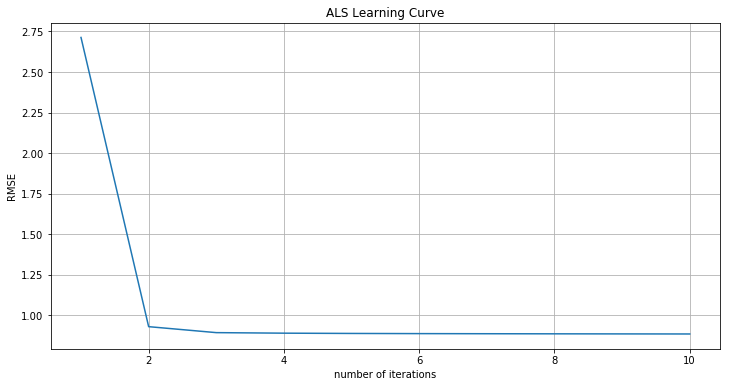

In [20]:
# create an array of num_iters
iter_array = list(range(1, 11))

# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.05, 20)

#### Model testing

##### And finally, make a prediction and check the testing error using out-of-sample data

In [ ]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))

# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)

# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

##### Make movie recommendation to myself
##### We need to define a function that takes new user's movie rating and output top 10 recommendations

In [22]:
def get_movie_id(df_movies, fav_movie_list):
    """
    return all movie_id(s) of user's favorite movies
    
    Parameters
    ----------
    df_movies: spark Dataframe, movies data
    
    fav_movie_list: list, user's list of favorite movies
    
    Return
    ------
    movie_id_list: list of movie_id(s)
    """
    movie_id_list = []
    for movie in fav_movie_list:
        movie_ids = df_movies \
            .filter(movies.title.like('%{}%'.format(movie))) \
            .select('movie_id') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        movie_id_list.extend(movie_ids)
    return list(set(movie_id_list))


def add_new_user_to_data(train_data, movie_id_list, spark_context):
    """
    add new rows with new user, user's movie and ratings to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data
    
    movie_id_list: list, list of movie_id(s)

    spark_context: Spark Context object
    
    Return
    ------
    new train data with the new user's rows
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    
    # create new user rdd
    user_rows = [(new_id, movie_id, max_rating) for movie_id in movie_id_list]
    new_rdd = spark_context.parallelize(user_rows)
    
    # return new train data
    return train_data.union(new_rdd)


def get_inference_data(train_data, movies, movie_id_list):
    """
    return a rdd with the userid and all movies (except ones in movieId_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data
    
    movie_id_list: list, list of movie_id(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    
    # return inference rdd
    return movies.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in movie_id_list) \
        .map(lambda x: (new_id, x))


def make_recommendation(best_model_params, ratings_data, movies, fav_movie_list, n_recommendations, spark_context):
    """
    return top n movie recommendation based on user's input list of favorite movies
    
    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    movies: spark Dataframe, movies data

    fav_movie_list: list, user's list of favorite movies

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n movie recommendations
    """
    # modify train data by adding new user's rows
    movie_id_list = get_movie_id(movies, fav_movie_list)
    train_data = add_new_user_to_data(ratings_data, movie_id_list, spark_context)
    
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, movies, movie_id_list)
    
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n movieId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    # return movie titles
    return movies.filter(movies.movie_id.isin(topn_ids)) \
                    .select('title') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

In [25]:
my_favorite_movies = ['Toy Story']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 20, 'lambda_': 0.05}, 
    ratings_data=rating_data, 
    movies=movies, 
    fav_movie_list=my_favorite_movies, 
    n_recommendations=10, 
    spark_context=spark_context)

print('Recommendations for {}:'.format(my_favorite_movies[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for Toy Story:
1: Babe (1995)
2: Aladdin (1992)
3: Beauty and the Beast (1991)
4: Singin' in the Rain (1952)
5: Raiders of the Lost Ark (1981)
6: Little Mermaid; The (1989)
7: Bug's Life; A (1998)
8: Last Days; The (1998)
9: Third Miracle; The (1999)
10: Chicken Run (2000)
